Some libraries we'll be using:

In [142]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
import re
import sympy
from numpy.linalg import inv

## Theory

Some constants:

In [143]:
phi = 0.602 # fibre volume fraction
Ef = 230e9 # fibre tensile modulus (GPa)
Em = 2.4e9 # matrix tensile modulus (GPa)
Gf = 14e9 # fibre shear modulus (GPa)
Gm = 1.25e9 # matrix shear modulus (GPa)
sigma_f = 4900e6 # fibre UTS (MPa)
sigma_m = 60e6 # matrix UTS (MPa)
nu_m = 0.34 # matrix poisson ratio (_)
nu_f = 0.35 # fibre poisson ratio  (_)
angles = np.radians([0, 15, 30, 45, 90])
X1_T = 2282.0e6
X2_T = 53.55e6
X1_C = 1600.0e6
X2_C = 200.0e6
S6 = 99.0e6
Eps1_T = 0.02
Eps2_T = 0.0066
Gam6 = 0.0275
# Eps1_T = 0.0202
# Eps2_T = 0.004
# Gam6 = 0.13

Rule of mixtures to get simple properties:

Halpin-Tsai calculation:

In [144]:
def halpin_tsai_calc(p_m, p_f, phi, xi):
    """
    Calculates Halpin-Tsai propetry from matrix and fibre properties
    Parameters:
    ---------------------------------
    p_m, p_f: float
        Matrix and fibre properties
    phi: float
        Fibre volume fraction of composite
    xi: float
        xi in Halpin-Tsai eqn

    Returns:
    ----------------------------------
    p: float
        Halpin-Tsai property value
    """
    #chi = (p_f - p_m) / (p_f + xi * p_m)
    chi = ((p_f / p_m) - 1) / ((p_f/p_m) + xi)
    print("chi:", chi)
    p = (p_m * (1 + xi * chi * phi)) / (1 - chi * phi)
    return p

In [145]:
E1_th = phi * Ef + (1-phi) * Em
E2_th = (Ef * Em) / ((1-phi) * Ef + phi * Em)
nu12_th = phi * nu_f + (1-phi) * nu_m
G12_th = halpin_tsai_calc(Gm, Gf, phi, 1 + 40*phi**10)
E2_th_ht = halpin_tsai_calc(Em, Ef, phi, 2 + 40*phi**10)
nu21_th = E2_th / E1_th * nu12_th
nu21_th_ht = E2_th_ht / E1_th * nu12_th

chi: 0.8192738922472672
chi: 0.9668644290067554


In [146]:
E1_th/1e9

139.4152

In [147]:
E2_th/1e9

5.936454130137399

In [148]:
E2_th_ht/1e9

13.262789348524393

In [149]:
nu12_th

0.34602

In [150]:
nu21_th

0.014733916087414735

In [198]:
nu21_th_ht

0.03291743203306677

In [199]:
2 + 40*phi**10

2.2500488744019584

## Importing data

Locations of the data

In [152]:
UD0_path = '../data/0'
UD90_path = '../data/90'


DATADIRS = [UD0_path, UD90_path]

col_names = ['Sample elongation (mm)', 'Load (kN)', 'Time (s)', 'Longitudinal strain (_)',
            'Transverse strain (_)', 'Poisson ratio (%)', 'Real stress (GPa)', 'Real area (mm^2)']
exp_names = ['0', '90']

In [153]:
def import_data(datadirs, col_names, exp_names):
    """
    Imports data from experiments

    Parameters:
    ---------------------------------
    datafiles: list
        List of data locations
    col_names: list
        List of columns in the datafiles

    Returns:
    ----------------------------------
    data: pandas dataframe
        Dataframe containing parsed data
    """
    data_experiments = []
    for datadir in datadirs:
        data = []
        # import data in each module
        for root, subdirs, filenames in os.walk(datadir):
            subdirs.sort()
            for filename in filenames:
                if re.match('.*DAQ.*(csv|txt)\Z', filename):
                         print("Importing", root + '/' + filename)
                         file_path = os.path.join(root, filename)
                         data.append(pd.read_csv(file_path, header=None, sep=None, engine='python',
                                    names=col_names, na_values=['no info', '.', 'NaN'], skiprows=8))
                        
        # concatenate the data into one result
        concat_keys = ['Sample ' + str(i) for i in range(len(data))]
        data_experiments.append(pd.concat(data, keys = concat_keys, names=['Sample'])) 
        
    alldata = pd.concat(data_experiments, keys=exp_names, names=['Experiment'])


    return alldata

In [154]:
data = import_data(DATADIRS, col_names,exp_names)

Importing ../data/0/1/DAQ- Crosshead, … - (Timed).csv
Importing ../data/0/2/DAQ- Crosshead, … - (Timed).csv
Importing ../data/0/3/DAQ- Crosshead, … - (Timed).csv
Importing ../data/0/4/DAQ- Crosshead, … - (Timed).csv
Importing ../data/0/5/DAQ- Crosshead, … - (Timed).csv
Importing ../data/90/Test Run 1 08-11-2018 15 00 03/DAQ- Crosshead, … - (Timed).csv
Importing ../data/90/Test Run 2 08-11-2018 15 20 22/DAQ- Crosshead, … - (Timed).csv
Importing ../data/90/Test Run 3 08-11-2018 15 38 29/DAQ- Crosshead, … - (Timed).csv
Importing ../data/90/Test Run 4 08-11-2018 15 56 54/DAQ- Crosshead, … - (Timed).csv
Importing ../data/90/Test Run 5 08-11-2018 15 58 17/DAQ- Crosshead, … - (Timed).csv


In [155]:
data.head()

Sample elongation (mm)  Load (kN)  Time (s)  \
Experiment Sample                                                    
0          Sample 0 0               -0.001630  -0.009491      0.14   
                    1               -0.002609  -0.010253      0.24   
                    2               -0.003773  -0.011200      0.34   
                    3               -0.005217  -0.010219      0.44   
                    4               -0.007174  -0.010872      0.54   

                       Longitudinal strain (_)  Transverse strain (_)  \
Experiment Sample                                                       
0          Sample 0 0            -1.992070e-05              -0.000004   
                    1            -5.957210e-06              -0.000007   
                    2             5.479470e-06               0.000007   
                    3            -9.880680e-06               0.000005   
                    4            -4.195880e-07               0.000028   

                       Poisson ratio (%)  Real stress (GPa)  Real area (mm^2)  
Experiment Sample                                                              
0          Sample 0 0          19.174024          -0.000316         30.000114  
                    1         122.848117          -0.000342         30.000219  
                    2         133.424771          -0.000373         29.999781  
                    3         -46.390936          -0.000341         29.999863  
                    4       -6569.611359          -0.000362         29.999173

And delete unnecessary columns

In [156]:
del data['Poisson ratio (%)']
del data['Real stress (GPa)']
del data['Real area (mm^2)']

Make a raw table and then delete the time column

In [157]:
raw_data =  data.loc['0', 'Sample 0'].head()
del raw_data['Time (s)']

In [158]:
print(raw_data.to_latex(float_format='%.2g', escape = True))

\begin{tabular}{lrrrr}
\toprule
{} &  Sample elongation (mm) &  Load (kN) &  Longitudinal strain (\_) &  Transverse strain (\_) \\
\midrule
0 &                 -0.0016 &    -0.0095 &            -1.992070e-05 &               -3.8e-06 \\
1 &                 -0.0026 &      -0.01 &            -5.957210e-06 &               -7.3e-06 \\
2 &                 -0.0038 &     -0.011 &             5.479470e-06 &                7.3e-06 \\
3 &                 -0.0052 &      -0.01 &            -9.880680e-06 &                4.6e-06 \\
4 &                 -0.0072 &     -0.011 &            -4.195880e-07 &                2.8e-05 \\
\bottomrule
\end{tabular}



And plot a few cases

In [159]:
quickplot_load = lambda data, separator: sns.relplot(x='Sample elongation (mm)', y='Load (kN)', 
                                                data=data, kind='line', hue=separator)
def plot_sample_data(_data, _x, _y):
    data_reset = _data.reset_index(level='Sample')
    return sns.relplot(x=_x, y=_y, data=data_reset, kind='line', hue='Sample')

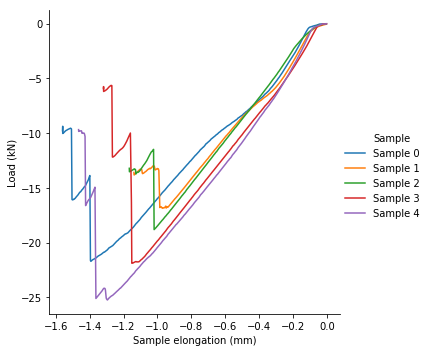

In [160]:
data_reset = data.reset_index(level='Sample')
fig = quickplot_load(data_reset.loc['0'], 'Sample')
fig.savefig('../figs/0_raw.pdf', format = 'pdf')
fig = quickplot_load(data_reset.loc['90'], 'Sample')
fig.savefig('../figs/90_raw.pdf', format = 'pdf')


That works, adding the rest of the geometry

In [161]:
def add_geometry(data, TESTS, WIDTHS, THICKNESSES, FVFS):
    data = data.assign(Width=25e-3, Thickness=2e-3, FVF=0.602)
    data = data.rename(columns = {'Width':'Width (m)', 'Thickness': 'Thickness (m)', 'FVF': 'FVF (_)'})
    for _test, _width, _thickness, _fvf in zip(TESTS, WIDTHS, THICKNESSES, FVFS):
        for i in range(len(_width)):
            sample_name = 'Sample ' + str(i)
            data.loc[(_test, sample_name), 'Width (m)'] = _width[i]
            data.loc[(_test, sample_name), 'Thickness (m)'] = _thickness[i]
            data.loc[(_test, sample_name), 'FVF (_)'] = _fvf
    return data
    
UD0_width = np.array([15.21, 15.07, 15.09, 15.17, 15.08]) * 1e-3
UD90_width = np.array([15.16, 15.15, 15.16, 15.15, 15.10]) * 1e-3
UD0_thickness = np.array([2.06, 1.95, 1.70, 2.11, 2.06]) * 1e-3
UD90_thickness = np.array([2.03, 2.06, 2.00, 1.98, 2.11]) * 1e-3


UD0_FVF = 0.602
UD90_FVF = 0.602


WIDTHS = [UD0_width, UD90_width]
THICKNESSES = [UD0_thickness, UD90_thickness]
FVFS = [UD0_FVF, UD90_FVF]
data = add_geometry(data, exp_names, WIDTHS, THICKNESSES, FVFS)

# Stress calculations
The standard asks for engineering stress, so we need the sample areas.

In [162]:
areas = data['Width (m)'] * data['Thickness (m)']

In [163]:
stresses = data['Load (kN)'] * 1000 / areas

In [164]:
data = data.assign(Area = areas, Stress = stresses)
data = data.rename(columns = {'Area':'Area (m^2)', 'Stress': 'Stress (Pa)'})

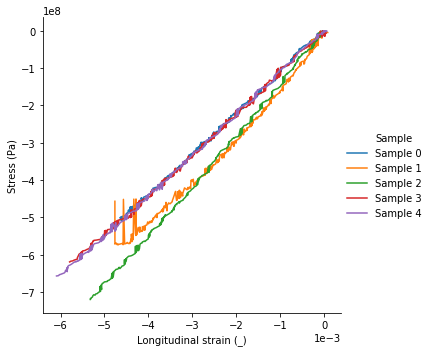

In [165]:
fig = plot_sample_data(data.loc['0'][data.loc['0', 'Sample elongation (mm)'] > -1], \
                       'Longitudinal strain (_)', 'Stress (Pa)')
for ax in fig.axes.flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
fig.savefig('../figs/0_ss.pdf', format = 'pdf')

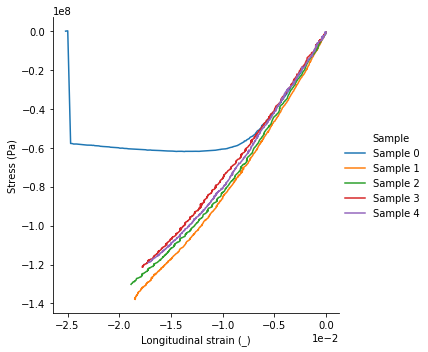

In [166]:
fig = plot_sample_data(data.loc['90'][data.loc['90', 'Sample elongation (mm)'] > -1.5], \
                    'Longitudinal strain (_)', 'Stress (Pa)')
for ax in fig.axes.flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
fig.savefig('../figs/90_ss.pdf', format = 'pdf')

In [167]:
fig = plot_sample_data(data.loc['0'][data.loc['0', 'Sample elongation (mm)'] > -1], \
                    'Longitudinal strain (_)', 'Transverse strain (_)')
for ax in fig.axes.flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
fig.savefig('../figs/0_sstrain.pdf', format = 'pdf')

In [168]:
fig = plot_sample_data(data.loc['90'][data.loc['90', 'Sample elongation (mm)'] > -1.5], \
                    'Longitudinal strain (_)', 'Transverse strain (_)')
for ax in fig.axes.flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0), axxxxxxxxxxxxxxxis='both')
fig.savefig('../figs/90_sstrain.pdf', format = 'pdf')

# Analysis

In [169]:
def calc_moduli(data, strain_col, strain_low, strain_high, samples, name):
    """
    calculates modulus from data
    """
    # access the index property to get the no. of samples
    moduli = []
    sample_names = []

    for i in range(samples[0], samples[1]):
        # get index of lower stress value
        sample_name = "Sample " + str(i)
        sample_data = data.loc[sample_name]
        idx_low = (sample_data[strain_col] - strain_low).abs().idxmin()
        idx_high = (sample_data[strain_col] - strain_high).abs().idxmin()
        e_h = sample_data['Stress (Pa)'].iloc[idx_high]
        e_low = sample_data['Stress (Pa)'].iloc[idx_low]
        print('high', e_h, 'low', e_low)
        delta_stress = sample_data['Stress (Pa)'].iloc[idx_high] - sample_data['Stress (Pa)'].iloc[idx_low]
        delta_strain = strain_high - strain_low
        moduli.append(delta_stress / delta_strain / 1e9)
        sample_names.append(sample_name),
    return pd.DataFrame(moduli, index = sample_names, columns = [name])
        

In [170]:
def calc_poisson(data, strain_long, strain_trans, strain_low, strain_high, samples, name):
    """
    calculates modulus from data
    """
    # access the index property to get the no. of samples
    moduli = []
    sample_names = []
    for i in range(samples[0], samples[1]):
        # get index of lower stress value
        sample_name = "Sample " + str(i)
        sample_data = data.loc[sample_name]
        idx_low = (sample_data[strain_long] - strain_low).abs().idxmin()
        idx_high = (sample_data[strain_long] - strain_high).abs().idxmin()
        delta_e1 = sample_data[strain_long].iloc[idx_high] - sample_data[strain_long].iloc[idx_low]
        delta_e2 = sample_data[strain_trans].iloc[idx_high] - sample_data[strain_trans].iloc[idx_low]
        moduli.append(-delta_e2 / delta_e1)
        sample_names.append(sample_name)
    return pd.DataFrame(moduli, index = sample_names, columns = [name])

In [171]:
def get_stats(data):
    mean = data.mean()
    std = data.std()
    cov = std / mean * 100
    return mean, std, cov

In [172]:
def get_vals(data, strain_low, strain_high, samples):
    X1 = pd.DataFrame(data['Stress (Pa)'].abs().max(level='Sample') / 1e6)
    X1.columns = ['$X_{1}^{T}$ (MPa)']
    E1 = calc_moduli(data, 'Longitudinal strain (_)', strain_low, strain_high, samples, '$E_{1}$ (GPa)')
    nuxy = calc_poisson(data, 'Longitudinal strain (_)', 'Transverse strain (_)',  strain_low, strain_high, samples, '$\nu_{xy}$ (\_)')
    return pd.concat([X1, E1, nuxy,], axis = 1, sort=False) 

In [173]:
def get_vals_gauge(data, strain_low, strain_high):
    E1_gauge = calc_moduli(data, 'Strain gauge 0 (_)', strain_low, strain_high, 5, '$E_{x}$')
    nuxy_gauge = calc_poisson(data, 'Strain gauge 0 (_)', 'Transverse strain gauge (_)',  strain_low, strain_high, 5, '$\nu_{xy}$')
    etaxy_gauge =  calc_poisson(data, 'Strain gauge 0 (_)', 'Shear strain gauge (_)',  strain_low, strain_high, 5, '$\eta_{xy}$')
    etaxy_gauge = etaxy_gauge.abs()
    return pd.concat([E1_gauge, nuxy_gauge, etaxy_gauge], axis = 1, sort=False) 

## 0 deg.

In [174]:
vals_0 = get_vals(data.loc['0'], -0.001, -0.003, [0, 5])
vals_0.describe()

high -327985911.3890165 low -98413373.77044994
high -399114362.6750379 low -162880748.5473772
high -422966490.274042 low -149315342.24493742
high -340566954.2577487 low -120435045.41831596
high -332355421.16801006 low -105796806.69519842


$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)  $\nu_{xy}$ (\_)
count           5.000000       5.000000         5.000000
mean          699.165243     118.614782         0.334261
std            86.656572      10.584047         0.142885
min           573.612006     110.065954         0.115484
25%           683.649399     113.279307         0.309055
50%           692.845670     114.786269         0.327168
75%           733.290362     118.116807         0.431545
max           812.428778     136.825574         0.488051

In [175]:
vals_0

$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)  $\nu_{xy}$ (\_)
Sample                                                     
Sample 0         692.845670     114.786269         0.431545
Sample 1         573.612006     118.116807         0.115484
Sample 2         733.290362     136.825574         0.488051
Sample 3         683.649399     110.065954         0.309055
Sample 4         812.428778     113.279307         0.327168

## 90 deg.

We get rid of sample 0 because it failed too early

In [176]:
data2 = data.copy()

In [177]:
data2 =data2.drop(labels = [('90', 'Sample 0')])

In [178]:
vals_90 = get_vals(data2.loc['90'], -0.001, -0.003, [1,5])
vals_90.describe()

high -29463550.70978124 low -10796708.24997398
high -27466126.293494392 low -10414481.855004948
high -24200157.64597293 low -8588965.179069974
high -25468362.881442048 low -8862112.737383666


$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)  $\nu_{xy}$ (\_)
count           4.000000       4.000000         4.000000
mean          141.674556       8.491991         0.037694
std             0.779803       0.636647         0.038221
min           141.084388       7.805596         0.003840
25%           141.238361       8.178743         0.012500
50%           141.399441       8.414474         0.028529
75%           141.835636       8.727722         0.053722
max           142.814954       9.333421         0.089877

In [179]:
vals_90

$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)  $\nu_{xy}$ (\_)
Sample                                                     
Sample 1         141.289685       9.333421         0.003840
Sample 2         142.814954       8.525822         0.041670
Sample 3         141.084388       7.805596         0.015387
Sample 4         141.509197       8.303125         0.089877

## Summaries

In [180]:
def make_summary(*args):
    args = list(args)
    summary = args.pop(0)
    
    for arg in args:
        summary = summary.join(arg)
   
    mean = summary.mean()
    std_dev = summary.std()
    DOV = summary.std() / summary.mean() * 100

    summary.loc['Mean'] = mean
    summary.loc['Standard deviation'] = std_dev
    summary.loc['DOV'] = DOV

    latex_tab = summary.to_latex(float_format='%.2f', escape = False)
    
    print(latex_tab)
    return summary, latex_tab

In [181]:
UD0_summary, _ = make_summary(vals_0)

\begin{tabular}{lrrr}
\toprule
{} &  $X_{1}^{T}$ (MPa) &  $E_{1}$ (GPa) &  $\nu_{xy}$ (\_) \\
Sample             &                    &                &                  \\
\midrule
Sample 0           &             692.85 &         114.79 &             0.43 \\
Sample 1           &             573.61 &         118.12 &             0.12 \\
Sample 2           &             733.29 &         136.83 &             0.49 \\
Sample 3           &             683.65 &         110.07 &             0.31 \\
Sample 4           &             812.43 &         113.28 &             0.33 \\
Mean               &             699.17 &         118.61 &             0.33 \\
Standard deviation &              86.66 &          10.58 &             0.14 \\
DOV                &              12.39 &           8.92 &            42.75 \\
\bottomrule
\end{tabular}



In [182]:
UD90_summary, _ = make_summary(vals_90)

\begin{tabular}{lrrr}
\toprule
{} &  $X_{1}^{T}$ (MPa) &  $E_{1}$ (GPa) &  $\nu_{xy}$ (\_) \\
Sample             &                    &                &                  \\
\midrule
Sample 1           &             141.29 &           9.33 &             0.00 \\
Sample 2           &             142.81 &           8.53 &             0.04 \\
Sample 3           &             141.08 &           7.81 &             0.02 \\
Sample 4           &             141.51 &           8.30 &             0.09 \\
Mean               &             141.67 &           8.49 &             0.04 \\
Standard deviation &               0.78 &           0.64 &             0.04 \\
DOV                &               0.55 &           7.50 &           101.40 \\
\bottomrule
\end{tabular}



Comparison with theory

In [183]:
vals_0

$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)  $\nu_{xy}$ (\_)
Sample                                                               
Sample 0                   692.845670     114.786269         0.431545
Sample 1                   573.612006     118.116807         0.115484
Sample 2                   733.290362     136.825574         0.488051
Sample 3                   683.649399     110.065954         0.309055
Sample 4                   812.428778     113.279307         0.327168
Mean                       699.165243     118.614782         0.334261
Standard deviation          86.656572      10.584047         0.142885
DOV                         12.394291       8.923042        42.746581

Error analysis

In [184]:
error_mult = lambda val, errors: val * np.sqrt(np.sum(np.square(errors)))

Es

In [185]:
error_mult(118.61, [0.03, 0.01, 0.08, 0.02])

10.47535156355146

In [186]:
error_mult(8.49, [0.03, 0.01, 0.08, 0.02])

0.7498164975512341

Xs

In [187]:
error_mult(699.17, [0.03, 0.01, 0.08])

60.14487756958193

In [188]:
error_mult(141.67, [0.03, 0.01, 0.08])

12.186914205819289

nus

In [189]:
error_mult(0.33, [0.02, 0.02])

0.009333809511662428

In [190]:
error_mult(0.04, [0.02, 0.02])

0.001131370849898476

In [191]:
(2320-700)/700

2.3142857142857145

In [192]:
0.01/0.33

0.030303030303030304

The variation in $X_{1}^C$ is 40\% larger than could be expected from measurement error alone. The degree of variation in Poisson ratio measurements is 43\%\ for the 0\degree\ test and 101\%\ for the 90\degree\ test. This makes quantitative observations of this quantity difficult. 

All those errors can be attributed to errors in experimental procedure outlined in the text above. To reiterate:
\begin{enumerate}
    \item Sample dimensions were not within the specification of the test (the variation in sample thickness was too large, the ends of the samples were not square to the axis of loading. (section \ref{})
    \item The clamping torques in the 0\degree\ tests were too large. (section \ref{})
    \item Non standard sample mounting method was used (section \ref{})
    \item The transverse strains were measured incorrectly --- the DIC suffered from perspective errors due to inappropriate perspective (section \ref{})
    \item The samples could have sufferred from Euler buckling. No attempt was made to detect it. (section \ref{})
\end{enumerate}

Only measurements of compressive moduli have standard deviations equal to or lower than the estimated experimental error. This is probably because the measurement of this quantity did not rely on transverse strain estimation from the DIC, and was done for relatively small strains and stresses, where the effects of inappropriate clamping and mounting have not manifested yet. 
Another meaningful result from this experiment was in the measurement of strength of the 90\degree\ samples. The results are very close to each other (the standard deviation is less than 10\% of the estimated experimental error).

Comparison with theory, tensile testing and manufacturer's data

\paragraph{$E_{1}^{C}$} 
The measured value of $E_{1}^{C}$ is 18\% smaller than the one obtained from theory. This could be due to undetected Euler buckling, but data from the manufacturer's datasheet suggests otherwise. The tested samples were 4\% stiffer than reported by the manufacturer. Another possible reason why samples are weaker than predicted by theory is that the theory does not account for microbuckling of the carbon fibres. However, samples in the tensile test were 7\% weaker than in the compressive test. Assuming that the manufacturer's data is correct, it is difficult to give a definite reason for this discrepancy between theory and data other than the fact that there must exist a failure mechanism for which the Rule of Mixtures/Halpin-Tsai equations do not account.

\paragraph{$E_{2}^{C}$}
The measured value of $E_{2}^{C}$ is between the two values obtained from theoretical calculations. It is 30\% larger than the one obtained from Rule of Mixtures and 56\% lower than the one calculated from Halpin-Tsai equations. The difference between ROM results and measurements can be explained by the fact that the ROM expression is a lower bound on the strength of a composite. It assumes equal strain along the sample length, which is not a good assumption in this testing situation. In reality, fibres will be strained  Departure from the HT prediction can be explained by the use of inappropriate constants. Because the modulus of the  particular resin used in the prepreg could not be found in the datasheet, a generic one was taken from the lecture notes. This value may have been too high. The fact that the stiffness measured by the prepreg manufacturer was very close to the one measured in this experiment (10\% difference, almost within the experimental uncertainty of 8\%) supports this hypothesis. Alternatively, the lower stiffness could simply be a result of the departures from the standard testing procedure described above.

\paragraph{$X_{1}^{C}$, $X_{2}^{C}}
As has also been described above, experimental errors make the estimation of sample strength from the available data very difficult. All that can be said is that $X_{2}^{C}$ is 41\% lower than reported by the manufacturer. This suggests that, again the experimental procedure followed was not accurate. 

$X_{1}^{C}$ is significantly lower (2.3 times lower) than strength measured in the tensile test. This was to be expected --- the fibres, which provide most of the strength in the 1-axis are susceptible to failure through microbuckling in a compressive test, which weakens the composite. $X_{2}^{C}$, however is 7 times larger than was measured in the tensile test. This is because in this direction the strength is dominated by the properties of the polymer matrix, which is much stronger in compression than in tension.

\paragraph{$\nu_{12}$, $\nu{21}}
As was described above, the measurements of Poisson ratios have degrees of variance of 43\% for $\nu_{12}$ and 100\% for $\nu{21}$, which makes a quantitative comparison with theory impossible, because, due to the spread of the data, an agreement may well be coincidental. The mean value of $\nu_{12}$ is only 5\% lower than estimated from theory, but this result is not significant. $\nu_{21}$ is 4 times larger than predicted by theory, but this is, again, based on very low quality data. Qualitatively, however, $\nu_{21}$ is much lower than $\nu{12}$, which is consistent with the theoretical model. In a similar vein one could also conclude that the value of $\nu_{12}$ obtained in tensile testing was very similar to the one obtained in tensile testing (3\% difference). Tensile measurement of $\nu{21}$ was also plagued by a 110\% degree of variation, so any quantitative comparison is, again, impossible.





In [197]:
data.loc['0'].describe()

Sample elongation (mm)    Load (kN)     Time (s)  \
count             3251.000000  3251.000000  3251.000000   
mean                -0.717776   -11.034902    33.353922   
std                  0.427401     6.359985    20.072167   
min                 -1.560432   -25.237938     0.120000   
25%                 -1.057593   -15.645695    16.340000   
50%                 -0.705823   -10.958507    32.619999   
75%                 -0.353634    -6.083240    48.840000   
max                 -0.000885    -0.009491    80.839996   

       Longitudinal strain (_)  Transverse strain (_)    Width (m)  \
count              3251.000000            3251.000000  3251.000000   
mean                 -0.005741               0.001273     0.015131   
std                   0.011872               0.001703     0.000058   
min                  -0.072287              -0.004175     0.015070   
25%                  -0.004970               0.000502     0.015080   
50%                  -0.003291               0.001212     0.015090   
75%                  -0.001772               0.001797     0.015170   
max                   0.000080               0.009921     0.015210   

       Thickness (m)       FVF (_)   Area (m^2)   Stress (Pa)  
count    3251.000000  3.251000e+03  3251.000000  3.251000e+03  
mean        0.001991  6.020000e-01     0.000030 -3.661890e+08  
std         0.000141  3.331181e-14     0.000002  2.089301e+08  
min         0.001700  6.020000e-01     0.000026 -8.124288e+08  
25%         0.001950  6.020000e-01     0.000029 -5.217737e+08  
50%         0.002060  6.020000e-01     0.000031 -3.611855e+08  
75%         0.002060  6.020000e-01     0.000031 -2.009250e+08  
max         0.002110  6.020000e-01     0.000032 -3.029048e+05